In [7]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import set_config
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [8]:
#to make the preprocessor look like a diagram
set_config(display="diagram")

In [10]:
df= pd.read_csv(r"C:\Users\yarde\Downloads\hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


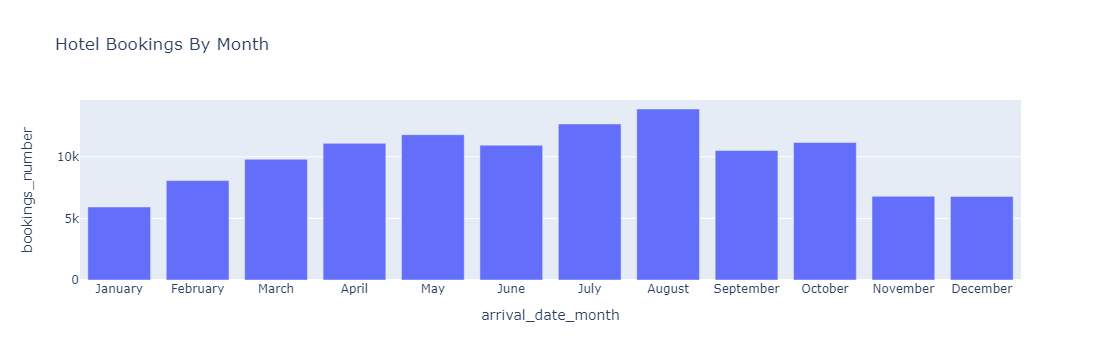

In [23]:
import calendar
booking_by_month= df.groupby('arrival_date_month', as_index=False)[['hotel']].count().rename(columns= {'hotel':'bookings_number'})

months= list(calendar.month_name)[1:]
fig= px.bar(booking_by_month, x='arrival_date_month', y='bookings_number', 
            title='Hotel Bookings By Month',
            #starts from April so I changed it
            category_orders={"arrival_date_month": months})
fig.show()

In [24]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [25]:
features_num = [
    "lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies", "is_repeated_guest" ,
    "previous_cancellations", "previous_bookings_not_canceled", "agent", "company", 
    "required_car_parking_spaces", "total_of_special_requests", "adr"]


features_cat = [
    "hotel", "arrival_date_month", "meal", "market_segment", "distribution_channel", 
    "reserved_room_type", "deposit_type", "customer_type"]

features = features_num + features_cat

X= df[features]
y= df['is_canceled']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

one-hot encode all categorical features = flipping a categorical column like: customer_type = ['Business','Leisure','Conference']

to three columns 'is_Business', 'is_Leisure', 'is_Conference'

turning categories to numerical columns

***Preprocess the data***

In [27]:
#SimpleImputer: replaces missing values (NaNs) with some specified value, constant changes it to None
transformer_num= SimpleImputer(strategy= 'constant')

transformer_cat= Pipeline(steps= [("imputer",SimpleImputer(strategy= 'constant', fill_value='Unknown')),
                                  #handle_unknown values by ignoring them
                                  ("onehot", OneHotEncoder(handle_unknown='ignore'))]
                         )

#After building the transforming now I tell them on what to work:
preprocessor= ColumnTransformer(transformers= [('num', transformer_num, features_num),
                                               ('cat', transformer_cat, features_cat)]
                               )

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['lead_time', 'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled', 'agent',
                                  'company', 'required_car_parking_spaces',
                                  'total_of_special_requests', 'adr']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['hotel', 'arrival_date_month', 'meal',
                                  'market_segment', 'distribution_channel',
                                  'reserved_room_type', 'deposit_type',
                                  'customer_type'])])

***Fit model and evaluate it***

In [28]:
steps= Pipeline(steps= [('preprocessor', preprocessor),
                        ('model', DecisionTreeClassifier(random_state=42))]
               )
steps

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'agent', 'company',
                                                   'r...
                                                   'total_of_special_requests',
                                                   'adr']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [29]:
steps.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'agent', 'company',
                                                   'r...
                                                   'total_of_special_requests',
                                                   'adr']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

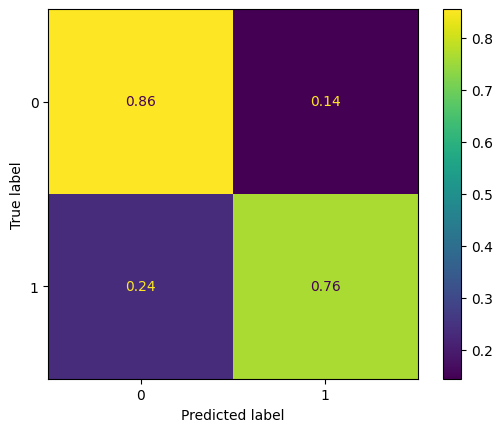

In [44]:
#see how well the model perfoems, calculate and visualize:
y_pred = steps.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=steps.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=steps.classes_)
disp.plot()

In [45]:
accuracy_score(y_test, y_pred)

0.8212580618142223

This is how it calculates accuracy:

conf = confusion_matrix(y_test, y_pred)

accuracy = float((conf[0][0] + conf[1][1]))/float(np.sum(conf))